In [2]:
import torch

device = torch.device("cuda")
device

device(type='cuda')

In [3]:
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import PIL
from transformers import YolosImageProcessor, YolosForObjectDetection, TrOCRProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
from torchvision import transforms
import torch.nn.functional as F
import io

In [4]:

# Yolo model for plate detection and cropping
yolo_processor = YolosImageProcessor.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')
yolo_model = YolosForObjectDetection.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection').to(device)

# Load model that I trained
trocr_processor = TrOCRProcessor.from_pretrained('GudaGuda05/Trocr_License_Plate', use_fast=False)
trocr_model = VisionEncoderDecoderModel.from_pretrained('model/model.pt').to(device)


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "cla

In [103]:
from torchvision import transforms
import torch.nn.functional as F
import io

# Using bounding boxes from YOLO model to 
# return list of cropped images that should
# contain the license plates

def crop_objects(boxes, image):
    #padding_to = 400
    images = []
    for box in boxes:
        normalized = len(box[box < 1]) == 4
        
        x_min, y_min, x_max, y_max = box

        if normalized:
            width, height = image.size
            x_min = int(x_min * width)
            y_min = int(y_min * height)
            x_max = int(x_max * width)
            y_max = int(y_max * height)

        # Ensure valid coordinates
        if x_min > x_max:
            x_min, x_max = x_max, x_min
        if y_min > y_max:
            y_min, y_max = y_max, y_min

        # Crop image
        try:
            img_cropped = image.crop([x_min, y_min, x_max, y_max])
            images.append(img_cropped)
        except:
            print(x_min, y_min, x_max, y_max, normalized)
            print(box)
            image.show()
            raise Exception

    return images

In [104]:
# Display the cropped images
def show_images(images):
    for image in images:
        image.show()

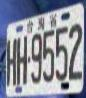

In [108]:
img = Image.open('image.png')
px = yolo_processor(img, return_tensors='pt').pixel_values.to(device)
output = yolo_processor.post_process_object_detection(yolo_model(px), threshold=.9)[0]["boxes"]
img

In [107]:
cropped_imgs = crop_objects(output, img)
show_images(cropped_imgs)

tensor(0.0450, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(0.0372, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(0.9852, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(1.0027, device='cuda:0', grad_fn=<UnbindBackward0>) False
tensor([0.0450, 0.0372, 0.9852, 1.0027], device='cuda:0',
       grad_fn=<UnbindBackward0>)


Exception: 

In [ ]:
p_image = trocr_processor(cropped_imgs, return_tensors='pt').to(device).pixel_values
trocr_output = trocr_model.generate(p_image)
results = trocr_processor.post_process_image_text_to_text(trocr_output)
results

['HH9552']